In [6]:
import mne
from collections import OrderedDict
from collections import namedtuple
import numpy as np
import copy
from re import findall

Reading C:\Users\jowan\erpclass\S1.fdt


C:\Users\jowan\AppData\Local\Temp\ipykernel_3704\1819913813.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_orig = mne.io.read_raw_eeglab('C:\\Users\\jowan\\erpclass\\S1.set')


Creating RawArray with float64 data, n_channels=34, n_times=2657480
    Range : 0 ... 2657479 =      0.000 ...  2657.479 secs
Ready.


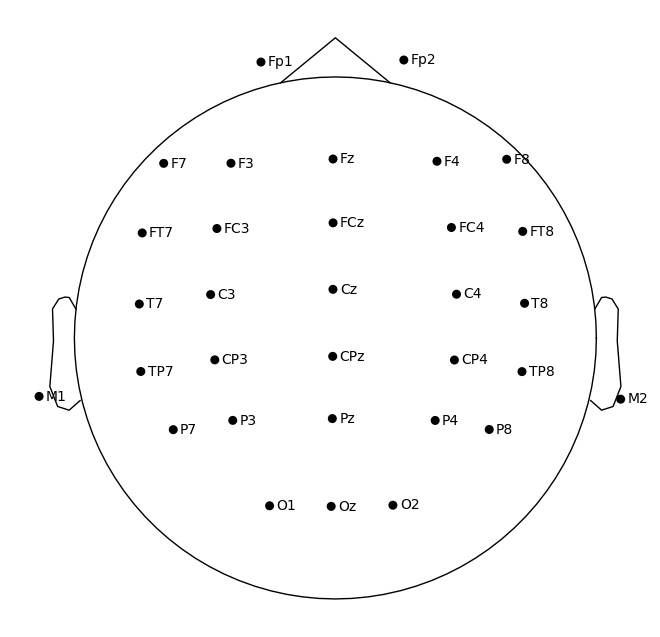

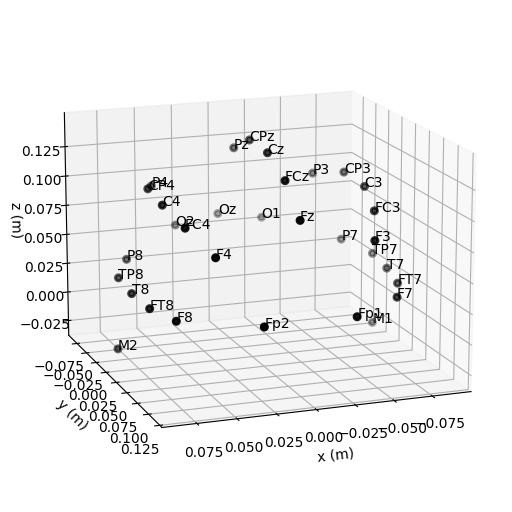

In [36]:
# Loading dataset (SET)
raw_orig = mne.io.read_raw_eeglab('C:\\Users\\jowan\\erpclass\\S1.set')

# Setting a built-in montage (i.e., adding channel locations) 
ch_names = raw_orig.ch_names
ch_names = [i if 'Z' not in i else i[:-1]+'z' for i in ch_names]
ch_names[ch_names.index('FP1')], ch_names[ch_names.index('FP2')] = 'Fp1', 'Fp2'
ch_types = ['eeg' if i not in ['HEO','VEO'] else 'eog' for i in ch_names]
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=1000)
info.set_montage('standard_1020', on_missing='ignore')

raw = mne.io.RawArray(data=raw_orig.get_data(), info=info)
montage = raw.get_montage();
montage.plot(kind='topomap', show=False)
fig_3d = montage.plot(kind='3d', show=False)
fig_3d.gca().view_init(azim=70, elev=15)

In [37]:
# Setting event annotations to raw (analogous to EEGLAB EventList)
# raw, created from scratch with mne.io.RawArray, has no associated events, so we must copy the event annotations from
# the original raw dataset raw_orig 
raw = raw.set_annotations(raw_orig.annotations)
raw.annotations

# Re-referencing
# I don't (yet) know how to modify this MNE method if one of the re-reference channels was the online reference
mne.set_eeg_reference(raw, ref_channels=['M1','M2'], ch_type='eeg', copy=False) # ch_type excludes HEO and VEO

Applying a custom ('EEG',) reference.


(<RawArray | 34 x 2657480 (2657.5 s), ~689.4 MB, data loaded>,
 array([-9.60791349e-07,  6.23253942e-07,  1.45586586e-06, ...,
         2.62178898e-05,  2.52450142e-05,  2.44884653e-05]))

In [38]:
# Bin-based epoching and baseline correction (mode: trial-level prestimulus average)

def parse_bdf(BDF_txt):
    '''Bin sizes should be in descending order: if Bin j ⊂ Bin i, then j > i '''
    f1 = open(BDF_txt)
    f2 = f1.read().split()
    f1.close()
    ev_seq, bins = [f2[3+4*i] for i in range(int((len(f2))/4))], [f2[2+4*i] for i in range(int((len(f2))/4))]
    tlock = [i.split('.') for i in ev_seq]
    
    parse1 = [[[] for j in i] for i in tlock]
    for i in range(len(tlock)):
        for j, y in enumerate(tlock[i]):
            parse1[i][j] = y.split('}')[:-1]
            
    parse2 = [[[] for j in i] for i in tlock]
    for i in range(len(tlock)):
        for j, y in enumerate(parse1[i]):
            for k, z in enumerate(y):
                if '-' in z:
                    l = int(findall(r'\d+', z)[0])
                    u = int(findall(r'\d+', z)[1])
                    parse2[i][j].append([str(n) for n in list(range(l, u+1))])
                else: parse2[i][j].append(findall(r'\d+', z))
    return parse2, bins


def raw_revised(raw, BDF_txt):
    bdf, bins = parse_bdf(BDF_txt)
    
    annot = copy.deepcopy(raw.annotations)
    items = {}
    for j, key in enumerate(annot[0].keys()): items[key] = []
    for i in range(len(annot)):
        for j, key in enumerate(annot[i].keys()):
            items[key].append(annot[i][key])
    
    for i in range(len(bdf)):
        for j in range(len(annot)):
            if annot[j]['description'] in bdf[i][1][0]:    # if the event code is the event time-locked to
                boo = [[[] for g in h] for h in bdf[i]]
                temp = [[True for g in h] for h in bdf[i]]
                for k, z in enumerate(bdf[i][0]):
                    try:
                        if annot[j-(len(bdf[i][0])-k)]['description'] in z: boo[0][k] = True
                        else: boo[0][k] = False
                    except IndexError:
                        boo[0] = None
                        break
                for k, z in enumerate(bdf[i][1]):
                    try:
                        if annot[j+k]['description'] in z: boo[1][k] = True
                        else: boo[1][k] = False
                    except IndexError:
                        boo[1] = None
                        break
                if boo == temp: items['description'][j] = bins[i]
            
    new_annot = mne.Annotations(np.array(items['onset'], dtype=object),
                                np.array(items['duration'], dtype=object),
                                np.array(items['description'], dtype=object), orig_time=None, ch_names=None)
    
    new_raw = raw.copy().set_annotations(new_annot)
    return new_raw, bins

def bin_based_epoch(raw, BDF_txt, tmin, tmax, baseline=None):
    new_raw, bins = raw_revised(raw, BDF_txt)
    ev_arr, ev_id = mne.events_from_annotations(new_raw)
    
    my_dict = {}
    for k in bins:
        try: my_dict[k] = ev_id[k]
        except KeyError: pass
    
    epochs = mne.Epochs(new_raw, ev_arr, event_id=my_dict, tmin=tmin, tmax=tmax, baseline=baseline,
                       reject_by_annotation=False)
    return epochs


epochs = bin_based_epoch(raw, 'S1_bdf_18bins.txt', tmin=-0.2, tmax=1.2, baseline=(-0.2,0))

Used Annotations descriptions: ['1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '14', '15', '16', '17', '18', '19', '199', '2', '20', '201', '202', '203', '204', '205', '206', '207', '208', '209', '21', '210', '22', '221', '222', '23', '230', '24', '240', '25', '250', '251', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', 'G', 

In [39]:
display(epochs.event_id)

bins = parse_bdf('S1_bdf_18bins.txt')[1]
for i in bins:
    print('\n', i)
    display(epochs[i])

{'G': 154,
 'UG': 160,
 'G/Incor': 159,
 'UG/Incor': 165,
 'G/Cor/LVF/NP': 155,
 'UG/Cor/LVF/NP': 161,
 'G/Cor/LVF/VP': 156,
 'UG/Cor/LVF/VP': 162,
 'G/Cor/RVF/NP': 157,
 'UG/Cor/RVF/NP': 163,
 'G/Cor/RVF/VP': 158,
 'UG/Cor/RVF/VP': 164}


 G


Number of events,136
Events,G: 1G/Cor/LVF/NP: 34G/Cor/LVF/VP: 29G/Cor/RVF/NP: 32G/Cor/RVF/VP: 34G/Incor: 6
Time range,-0.200 – 1.200 s
Baseline,-0.200 – 0.000 s



 UG


Number of events,136
Events,UG: 5UG/Cor/LVF/NP: 31UG/Cor/LVF/VP: 31UG/Cor/RVF/NP: 33UG/Cor/RVF/VP: 32UG/Incor: 4
Time range,-0.200 – 1.200 s
Baseline,-0.200 – 0.000 s



 G/Cor


Number of events,129
Events,G/Cor/LVF/NP: 34G/Cor/LVF/VP: 29G/Cor/RVF/NP: 32G/Cor/RVF/VP: 34
Time range,-0.200 – 1.200 s
Baseline,-0.200 – 0.000 s



 UG/Cor


Number of events,127
Events,UG/Cor/LVF/NP: 31UG/Cor/LVF/VP: 31UG/Cor/RVF/NP: 33UG/Cor/RVF/VP: 32
Time range,-0.200 – 1.200 s
Baseline,-0.200 – 0.000 s



 G/Incor


Number of events,6
Events,G/Incor: 6
Time range,-0.200 – 1.200 s
Baseline,-0.200 – 0.000 s



 UG/Incor


Number of events,4
Events,UG/Incor: 4
Time range,-0.200 – 1.200 s
Baseline,-0.200 – 0.000 s



 G/Cor/LVF


Number of events,63
Events,G/Cor/LVF/NP: 34G/Cor/LVF/VP: 29
Time range,-0.200 – 1.200 s
Baseline,-0.200 – 0.000 s



 G/Cor/RVF


Number of events,66
Events,G/Cor/RVF/NP: 32G/Cor/RVF/VP: 34
Time range,-0.200 – 1.200 s
Baseline,-0.200 – 0.000 s



 UG/Cor/LVF


Number of events,62
Events,UG/Cor/LVF/NP: 31UG/Cor/LVF/VP: 31
Time range,-0.200 – 1.200 s
Baseline,-0.200 – 0.000 s



 UG/Cor/RVF


Number of events,65
Events,UG/Cor/RVF/NP: 33UG/Cor/RVF/VP: 32
Time range,-0.200 – 1.200 s
Baseline,-0.200 – 0.000 s



 G/Cor/LVF/NP


Number of events,34
Events,G/Cor/LVF/NP: 34
Time range,-0.200 – 1.200 s
Baseline,-0.200 – 0.000 s



 UG/Cor/LVF/NP


Number of events,31
Events,UG/Cor/LVF/NP: 31
Time range,-0.200 – 1.200 s
Baseline,-0.200 – 0.000 s



 G/Cor/LVF/VP


Number of events,29
Events,G/Cor/LVF/VP: 29
Time range,-0.200 – 1.200 s
Baseline,-0.200 – 0.000 s



 UG/Cor/LVF/VP


Number of events,31
Events,UG/Cor/LVF/VP: 31
Time range,-0.200 – 1.200 s
Baseline,-0.200 – 0.000 s



 G/Cor/RVF/NP


Number of events,32
Events,G/Cor/RVF/NP: 32
Time range,-0.200 – 1.200 s
Baseline,-0.200 – 0.000 s



 UG/Cor/RVF/NP


Number of events,33
Events,UG/Cor/RVF/NP: 33
Time range,-0.200 – 1.200 s
Baseline,-0.200 – 0.000 s



 G/Cor/RVF/VP


Number of events,34
Events,G/Cor/RVF/VP: 34
Time range,-0.200 – 1.200 s
Baseline,-0.200 – 0.000 s



 UG/Cor/RVF/VP


Number of events,32
Events,UG/Cor/RVF/VP: 32
Time range,-0.200 – 1.200 s
Baseline,-0.200 – 0.000 s


C:\Users\jowan\AppData\Local\Temp\ipykernel_3704\518381801.py:2: FutureWarning: The current default events=None is deprecated and will change to events=True in MNE 1.6. Set events=False to suppress this warning.
  epochs.plot();


Using data from preloaded Raw for 20 events and 1401 original time points ...


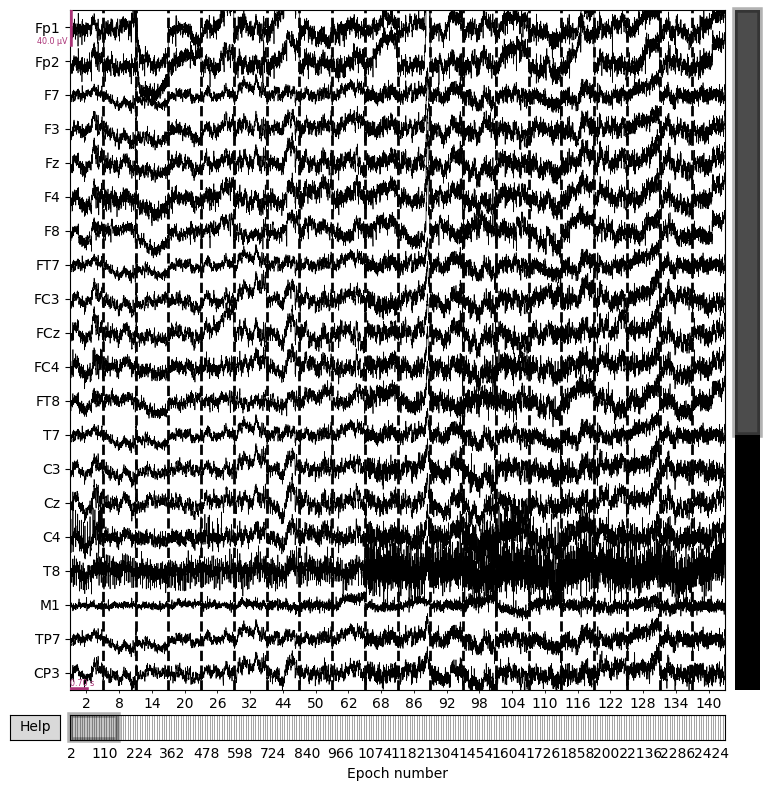

In [40]:
# Just... Don't do this kind of built-in plots in MNE (raw.plot() is also horrible)
epochs.plot();